In [209]:
%matplotlib  inline
import pandas as pd
from datetime import datetime
import quandl
import numpy as np
import matplotlib.pyplot as plt
import ssl
import sklearn.preprocessing as prep
import os
import ssl
import datetime
pd.core.common.is_list_like = pd.api.types.is_list_like
from pandas_datareader import data as pdr
import fix_yahoo_finance as yf
yf.pdr_override()
from scipy import poly1d
from pykalman import KalmanFilter

In [200]:
quandl.ApiConfig.api_key = "xoemPs9s3Dtwf3aQxQ-3"
start="2010-01-02"

INTC = pdr.get_data_yahoo("INTC",start=start)
MSFT = pdr.get_data_yahoo("MSFT",start=start)
AMZN = pdr.get_data_yahoo("AMZN",start=start)
NVDA = pdr.get_data_yahoo("NVDA",start=start)
GOOG = pdr.get_data_yahoo("GOOG",start=start)
NFLX = pdr.get_data_yahoo("NFLX",start=start)
FB = pdr.get_data_yahoo("FB",start=start)
# macro data 
EUROSTOXX50 = pdr.get_data_yahoo("FEZ",start=start)
SNP500 = pdr.get_data_yahoo("^GSPC",start=start)
CONS_DESCRETE = pdr.get_data_yahoo("XLY",start=start)
SNP_TECH = pdr.get_data_yahoo("XLK",start=start)
NASDAQ_COMP = pdr.get_data_yahoo("^IXIC",start=start)

# FRED & Treasury
yieldr = quandl.get("USTREASURY/REALYIELD", start_date=start, verify=False)
consumer_price_index = quandl.get("FRED/CPIAUCSL", start_date=start, verify=False)
gdpc = quandl.get("FRED/GDPC1", start_date=start, verify=False)
tnote_y10 = quandl.get("FRED/DGS10", start_date=start, verify=False)
financial_stress = quandl.get("FRED/STLFSI", start_date=start, verify=False)
effective_federal_fund_rate = quandl.get("FRED/FEDFUNDS", start_date=start, verify=False)


[*********************100%***********************]  1 of 1 downloaded


ValueError: zero-size array to reduction operation maximum which has no identity

In [ ]:
result = pd.concat([INTC, MSFT[['Close']].rename(columns={'Close': 'MSFT'})], axis=1)
result = pd.concat([result, AMZN[['Close']].rename(columns={'Close': 'AMZN'})], axis=1)
result = pd.concat([result, NVDA[['Close']].rename(columns={'Close': 'NVDA'})], axis=1)
result = pd.concat([result, GOOG[['Close']].rename(columns={'Close': 'GOOG'})], axis=1)
result = pd.concat([result, NFLX[['Close']].rename(columns={'Close': 'NFLX'})], axis=1)
result = pd.concat([result, FB[['Close']].rename(columns={'Close': 'FB'})], axis=1)
result = pd.concat([result, EUROSTOXX50[['Close']].rename(columns={'Close': 'EUROSTOXX50'})], axis=1)
result = pd.concat([result, SNP500[['Close']].rename(columns={'Close': 'SNP500'})], axis=1)
result = pd.concat([result, CONS_DESCRETE[['Close']].rename(columns={'Close': 'CONS_DESCRETE'})], axis=1)
result = pd.concat([result, SNP_TECH[['Close']].rename(columns={'Close': 'SNP_TECH'})], axis=1)
result = pd.concat([result, NASDAQ_COMP[['Close']].rename(columns={'Close': 'NASDAQ_COMP'})], axis=1)
# fred
result = pd.concat([result, yieldr[['5 YR']].rename(columns={'5 YR': 'yield_5y'})], axis=1)
result = pd.concat([result, tnote_y10.rename(columns={'Value': 'Tnote_10y'})], axis=1)

result = result.drop('Adj Close', axis=1)
result['Weekday'] = result.index.weekday
result['Daymonth'] = result.index.day
result['Month'] = result.index.month
result['Weakyear'] = result.index.weekofyear

result = result.dropna()

In [ ]:
result[['yield_5y']] = result[['yield_5y']].replace(0, 0.0000001)
result[['yield_5y']] = result[['yield_5y']]+10

def logReturns(df):
    log_ret = np.log(df) - np.log(df.shift(1))
    return log_ret

logRet = result[['High','Low','Close','MSFT','AMZN','NVDA','GOOG','NFLX','FB','EUROSTOXX50','SNP500','CONS_DESCRETE','SNP_TECH','NASDAQ_COMP','yield_5y','Tnote_10y']].apply(logReturns)

logRet.columns = [str(col) + '_logReturns' for col in logRet.columns]

result = pd.concat([result, logRet], axis=1)
scaler = prep.MaxAbsScaler().fit(result[['Volume']].values)
result['Volume_Scaled'] = scaler.transform(result[['Volume']].values)

result.head(3)

In [201]:
def tsi(close, r=25, s=13, fillna=True):
    m = close - close.shift(1)
    m1 = m.ewm(r).mean().ewm(s).mean()
    m2 = abs(m).ewm(r).mean().ewm(s).mean()
    tsi = m1/m2
    if fillna:
        tsi = tsi.fillna(0)
    return pd.Series(100*tsi, name='tsi')

def on_balance_volume(close, volume):
    df = pd.DataFrame([close, volume]).transpose()
    df['OBV'] = 0
    c1 = close < close.shift(1)
    c2 = close > close.shift(1)
    if c1.any():
        df.loc[c1, 'OBV'] = - volume
    if c2.any():
        df.loc[c2, 'OBV'] = volume
    return df['OBV']

def average_true_range(high, low, close, n=14, fillna=False):
    """Average True Range (ATR)
    The indicator provide an indication of the degree of price volatility.
    Strong moves, in either direction, are often accompanied by large ranges,
    or large True Ranges.
    http://stockcharts.com/school/doku.php?id=chart_school:technical_indicators:average_true_range_atr
    Args:
        high(pandas.Series): dataset 'High' column.
        low(pandas.Series): dataset 'Low' column.
        close(pandas.Series): dataset 'Close' column.
        n(int): n period.
    Returns:
        pandas.Series: New feature generated.
    """
    cs = close.shift(1)
    tr = high.combine(cs, max) - low.combine(cs, min)
    tr = tr.ewm(n).mean()
    if fillna:
        tr = tr.fillna(0)
    return pd.Series(tr, name='atr')

def kst(close, r1=10, r2=15, r3=20, r4=30, n1=10, n2=10, n3=10, n4=15, nsig=9, fillna=True):
    rocma1 = (close / close.shift(r1) - 1).rolling(n1).mean()
    rocma2 = (close / close.shift(r2) - 1).rolling(n2).mean()
    rocma3 = (close / close.shift(r3) - 1).rolling(n3).mean()
    rocma4 = (close / close.shift(r4) - 1).rolling(n4).mean()
    kst = 100*(rocma1 + 2*rocma2 + 3*rocma3 + 4*rocma4)
    sig = kst.rolling(nsig).mean()
    if fillna:
        sig = sig.fillna(0)
    return pd.Series(sig, name='sig')

momentum  =  result[['Close']].diff(periods=5)
momentum  =  momentum[~np.isnan(momentum)]
result['TradingRange'] = result["High"]-result["Low"]
result['OBV'] = on_balance_volume(result["Close"], result["Volume"])
result['TSI'] = tsi(result["Close"])
result['ATR'] = average_true_range(result["High"],result["Low"],result["Close"])
result['HighestHigh'] = result['High'].rolling(window=21,center=False,min_periods=1).max()
result['LowestLow'] = result['Low'].rolling(window=21,center=False,min_periods=1).min()

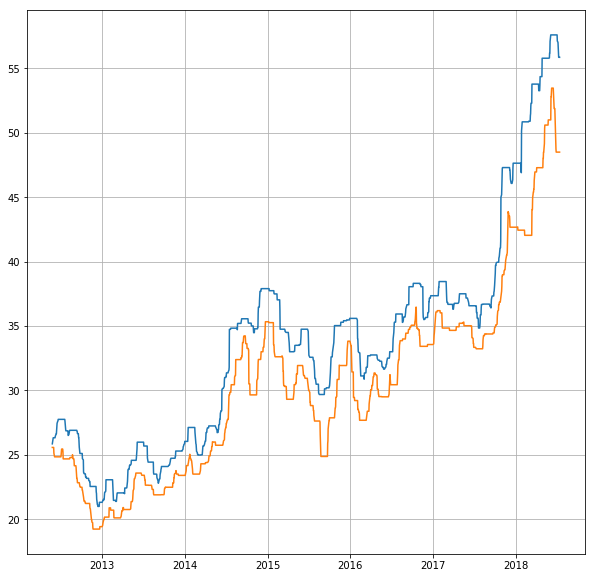

In [207]:
from matplotlib.pyplot import figure
figure(num=None, figsize=(10, 10))
plt.plot(result['HighestHigh'])
plt.plot(result['LowestLow'])
plt.grid(True)

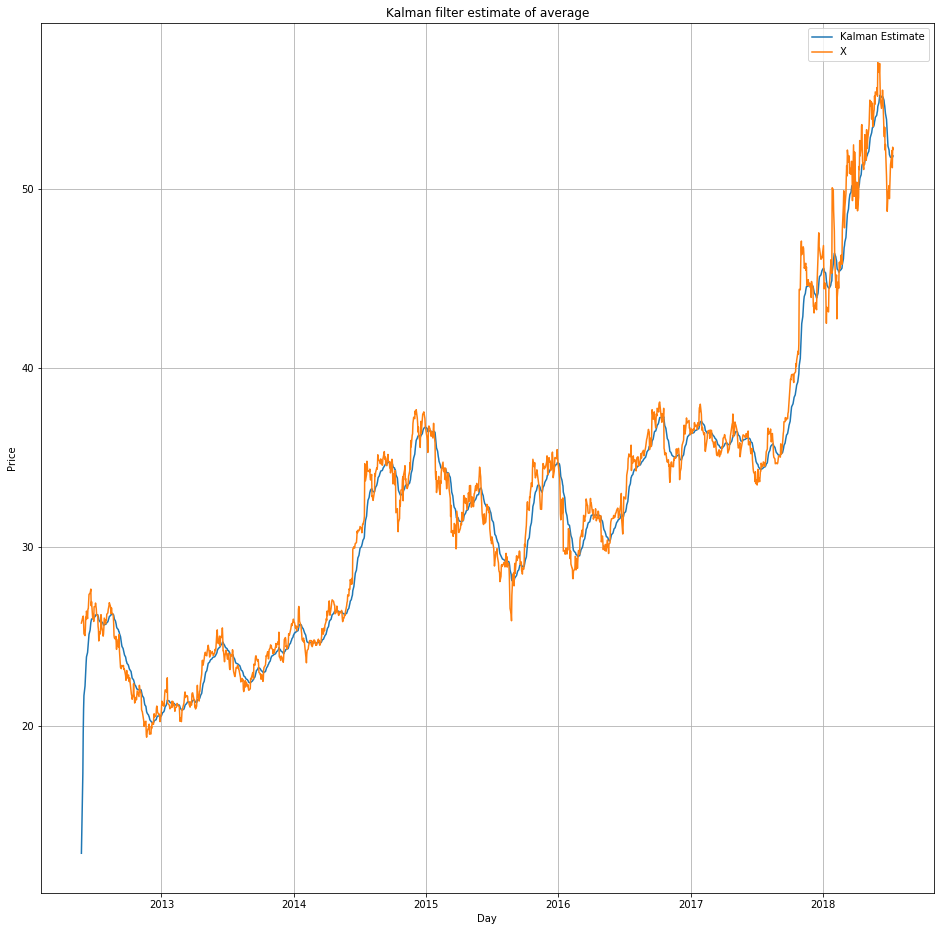

In [231]:
x = (result[['Close']])
kf = KalmanFilter(transition_matrices = [1],
                  observation_matrices = [1],
                  initial_state_mean = 0,
                  initial_state_covariance = 1,
                  observation_covariance=1,
                  transition_covariance=.01)
state_means, _ = kf.filter(x.values)
state_means = pd.Series(state_means.flatten(), index=x.index)

plt.rc("figure",figsize=(16,16))
# Plot original data and estimated mean
plt.plot(state_means)
plt.plot(x)
plt.title('Kalman filter estimate of average')
plt.legend(['Kalman Estimate', 'X'])
plt.xlabel('Day')
plt.ylabel('Price');
plt.grid(True)

In [249]:
scaler = prep.MaxAbsScaler().fit(result[['ATR']].values)
result['ATR_Scaled'] = scaler.transform(result[['ATR']].values)

scaler = prep.MaxAbsScaler().fit(result[['TSI']].values)
result['TSI_Scaled'] = scaler.transform(result[['TSI']].values)

scaler = prep.MaxAbsScaler().fit(result[['OBV']].values)
result['OBV_Scaled'] = scaler.transform(result[['OBV']].values)

scaler = prep.MaxAbsScaler().fit(result[['TradingRange']].values)
result['TradingRange_Scaled'] = scaler.transform(result[['TradingRange']].values)

scaler = prep.MaxAbsScaler().fit(result[['HighestHigh']].values)
result['HighestHigh_Scaled'] = scaler.transform(result[['HighestHigh']].values)

scaler = prep.MaxAbsScaler().fit(result[['LowestLow']].values)
result['LowestLow_Scaled'] = scaler.transform(result[['LowestLow']].values)


scaler = prep.MaxAbsScaler().fit(state_means.to_frame().values)
result['KFMean_Scaled'] = scaler.transform(state_means.to_frame().values)

ValueError: Length of values does not match length of index

In [197]:
result['TSI_Scaled'] =  result['TSI_Scaled'].replace(-1,0)
result = result.drop('TSI', axis=1)
result = result.drop('ATR', axis=1)
result = result.drop('OBV', axis=1)
result = result.drop('TradingRange', axis=1)
result = result.drop('HighestHigh', axis=1)
result = result.drop('LowestLow', axis=1)
# delete 0 values
result = result[result.TSI_Scaled != 0]

In [81]:
train_data = result.drop(['Open', 'High','Low','Close','Volume','MSFT','AMZN','NVDA','GOOG','NFLX','FB'
                          ,'EUROSTOXX50','SNP500','CONS_DESCRETE','SNP_TECH','NASDAQ_COMP','yield_5y'
                          ,'Tnote_10y'], axis=1)

In [82]:
pd.set_option('display.max_columns', 100)
train_data.head(11)

,Weekday,Daymonth,Month,Weakyear,High_logReturns,Low_logReturns,Close_logReturns,MSFT_logReturns,AMZN_logReturns,NVDA_logReturns,GOOG_logReturns,NFLX_logReturns,FB_logReturns,EUROSTOXX50_logReturns,SNP500_logReturns,CONS_DESCRETE_logReturns,SNP_TECH_logReturns,NASDAQ_COMP_logReturns,yield_5y_logReturns,Tnote_10y_logReturns,Volume_Scaled,ATR_Scaled,TSI_Scaled,OBV_Scaled
Date,,,,,,,,,,,,,,,,,,,,,,,,
2012-05-21,0,21,5,21,-0.014405,-0.014305,0.003064,0.016266,0.019725,0.017235,0.022578,0.025125,-0.116378,0.024675,0.015909,0.017462,0.024453,0.024324,-0.001124,0.023122,0.287905,0.270144,1.000000,0.287905
2012-05-22,1,22,5,21,0.003431,0.003887,-0.004599,0.000336,-0.012828,-0.012280,-0.021912,-0.057815,-0.093255,-0.005751,0.000486,0.003969,-0.003202,-0.002859,0.002247,0.022600,0.320239,0.267370,0.299555,-0.320239
2012-05-23,2,23,5,21,-0.029738,-0.033928,-0.022927,-0.022083,0.009015,0.024411,0.014311,0.060181,0.031749,-0.013428,0.001692,0.005345,0.001069,0.003881,0.003361,-0.034094,0.431062,0.354468,-0.393748,-0.431062
2012-05-24,3,24,5,21,0.010529,0.015529,0.008221,-0.001375,-0.009433,-0.026886,-0.009562,-0.023070,0.031680,-0.008439,0.001379,0.004624,-0.005712,-0.003775,0.004464,0.022858,0.258271,0.329825,-0.401581,0.258271
2012-05-25,4,25,5,21,0.002712,0.010220,0.003503,-0.000344,-0.010978,0.023665,-0.020299,-0.000712,-0.034497,0.002576,-0.002168,-0.001616,-0.002151,-0.000652,0.000000,-0.011364,0.133014,0.293853,-0.371630,0.133014
2012-05-29,1,29,5,22,0.018019,0.011278,0.013506,0.017059,0.008699,0.025479,0.004739,-0.011170,-0.101156,0.003302,0.011018,0.013768,0.013189,0.011723,0.002225,-0.005731,0.243828,0.295679,-0.269809,0.243828
2012-05-30,2,30,5,22,-0.004951,-0.002323,0.001532,-0.007470,-0.026040,-0.011863,-0.010334,-0.030709,-0.022796,-0.035418,-0.014439,-0.015850,-0.006394,-0.011783,-0.002225,-0.065305,0.230173,0.281371,-0.205559,0.230173
2012-05-31,3,31,5,22,-0.004592,-0.003883,-0.011160,-0.005126,0.017435,-0.011200,-0.012608,-0.059660,0.048807,0.003410,-0.002279,-0.002086,-0.004644,-0.003538,-0.003346,-0.024846,0.293824,0.273337,-0.190969,-0.293824
2012-06-01,4,1,6,22,-0.013905,-0.022827,-0.027464,-0.025678,-0.022274,-0.036874,-0.017156,-0.007754,-0.065620,-0.023341,-0.024951,-0.032063,-0.026484,-0.028652,0.002232,-0.078472,0.279955,0.287311,-0.231291,-0.279955


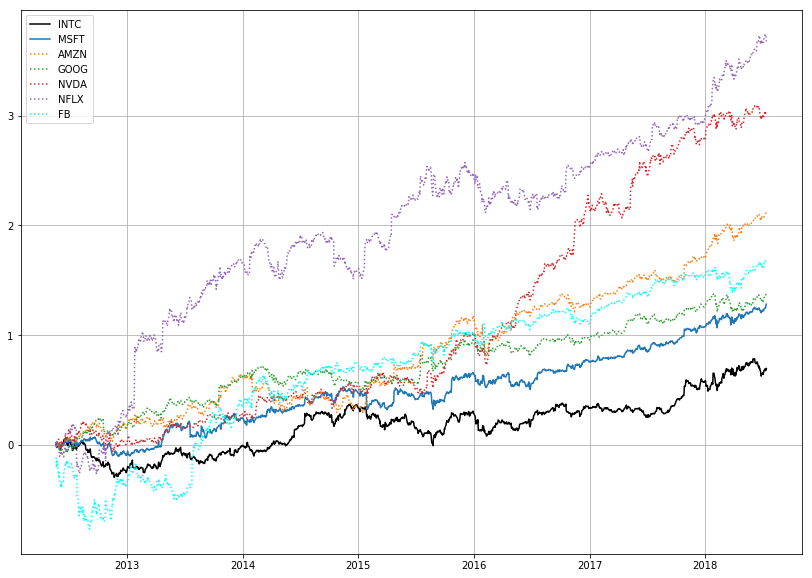

In [83]:
# Plot intel log returns to other 
figure(num=None, figsize=(14, 10))
plt.plot(np.cumsum(train_data[['Close_logReturns']]), color='xkcd:black',linestyle ='-')
plt.plot(np.cumsum(train_data[['MSFT_logReturns']]),linestyle ='-')
plt.plot(np.cumsum(train_data[['AMZN_logReturns']]),linestyle =':')
plt.plot(np.cumsum(train_data[['GOOG_logReturns']]),linestyle =':')
plt.plot(np.cumsum(train_data[['NVDA_logReturns']]),linestyle =':')
plt.plot(np.cumsum(train_data[['NFLX_logReturns']]),linestyle =':')
plt.plot(np.cumsum(train_data[['FB_logReturns']]),color='xkcd:cyan',linestyle =':')
plt.legend(['INTC','MSFT','AMZN','GOOG','NVDA','NFLX','FB'], loc='upper left')
plt.grid(True)
plt.show()

In [84]:
df_corr = train_data[['Close_logReturns','MSFT_logReturns','AMZN_logReturns','GOOG_logReturns','NVDA_logReturns',
                       'NFLX_logReturns','FB_logReturns']]

,Close_logReturns,MSFT_logReturns,AMZN_logReturns,GOOG_logReturns,NVDA_logReturns,NFLX_logReturns,FB_logReturns
Close_logReturns,1.000000,0.534796,0.312884,0.371741,0.438769,0.226223,0.243317
MSFT_logReturns,0.534796,1.000000,0.425174,0.524283,0.412067,0.253425,0.267783
AMZN_logReturns,0.312884,0.425174,1.000000,0.546642,0.293659,0.352504,0.360160
GOOG_logReturns,0.371741,0.524283,0.546642,1.000000,0.355666,0.347035,0.390170
NVDA_logReturns,0.438769,0.412067,0.293659,0.355666,1.000000,0.243086,0.245024
NFLX_logReturns,0.226223,0.253425,0.352504,0.347035,0.243086,1.000000,0.219954
FB_logReturns,0.243317,0.267783,0.360160,0.390170,0.245024,0.219954,1.000000


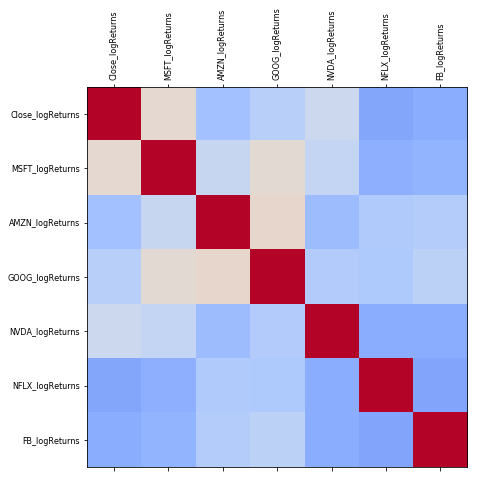

In [86]:
df = df_corr.corr()
import matplotlib.cm as cm
size = 7
fig, ax = plt.subplots(figsize=(size, size))
ax.matshow(df,cmap=cm.get_cmap('coolwarm'), vmin=0,vmax=1)
plt.xticks(range(len(df.columns)), df.columns, rotation='vertical', fontsize=8);
plt.yticks(range(len(df.columns)), df.columns, fontsize=8);
df

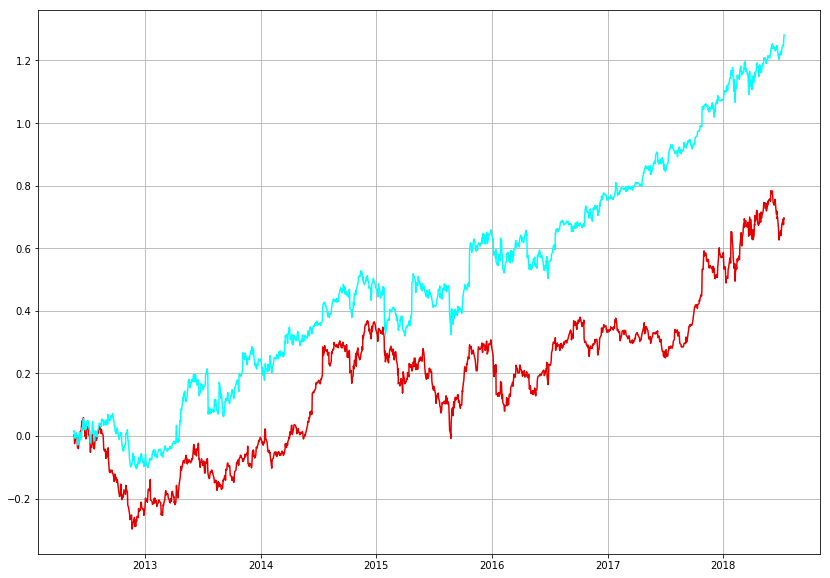

In [89]:
from matplotlib.pyplot import figure
figure(num=None, figsize=(14, 10))
plt.plot(np.cumsum(train_data[['Close_logReturns']]), color='xkcd:red',linestyle ='-')
plt.plot(np.cumsum(train_data[['MSFT_logReturns']]),color='xkcd:cyan',linestyle ='-')
plt.grid(True,which ='both')

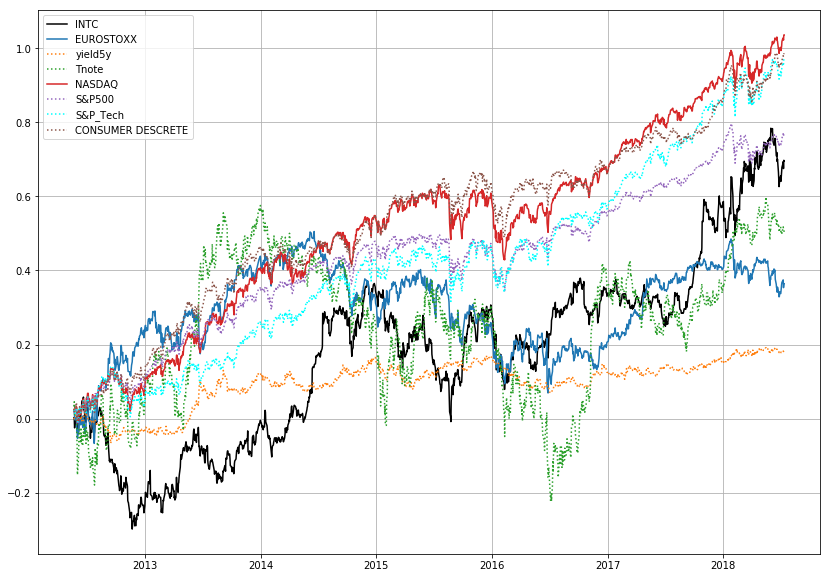

In [101]:
# Plot intel log returns to macro
from matplotlib.pyplot import figure
figure(num=None, figsize=(14, 10))
plt.plot(np.cumsum(train_data[['Close_logReturns']]), color='xkcd:black',linestyle ='-')
plt.plot(np.cumsum(train_data[['EUROSTOXX50_logReturns']]),linestyle ='-')
plt.plot(np.cumsum(train_data[['yield_5y_logReturns']]),linestyle =':')
plt.plot(np.cumsum(train_data[['Tnote_10y_logReturns']]),linestyle =':')
plt.plot(np.cumsum(train_data[['NASDAQ_COMP_logReturns']]),linestyle ='-')
plt.plot(np.cumsum(train_data[['SNP500_logReturns']]),linestyle =':')
plt.plot(np.cumsum(train_data[['SNP_TECH_logReturns']]),color='xkcd:cyan',linestyle =':')
plt.plot(np.cumsum(train_data[['CONS_DESCRETE_logReturns']]),linestyle =':')
plt.legend(['INTC','EUROSTOXX','yield5y','Tnote','NASDAQ','S&P500','S&P_Tech','CONSUMER DESCRETE'], loc='upper left')
plt.grid(True)
plt.show()

In [102]:
df_corr2 = train_data[['Close_logReturns','EUROSTOXX50_logReturns','yield_5y_logReturns','Tnote_10y_logReturns','NASDAQ_COMP_logReturns',
                       'SNP500_logReturns','SNP_TECH_logReturns','CONS_DESCRETE_logReturns']]

,Close_logReturns,EUROSTOXX50_logReturns,yield_5y_logReturns,Tnote_10y_logReturns,NASDAQ_COMP_logReturns,SNP500_logReturns,SNP_TECH_logReturns,CONS_DESCRETE_logReturns
Close_logReturns,1.000000,0.474435,0.055341,0.199786,0.625368,0.615558,0.660550,0.524666
EUROSTOXX50_logReturns,0.474435,1.000000,0.016145,0.358655,0.705002,0.762249,0.686664,0.676323
yield_5y_logReturns,0.055341,0.016145,1.000000,0.554535,0.082406,0.073316,0.074778,0.076522
Tnote_10y_logReturns,0.199786,0.358655,0.554535,1.000000,0.357210,0.380346,0.316811,0.356183
NASDAQ_COMP_logReturns,0.625368,0.705002,0.082406,0.357210,1.000000,0.941840,0.947801,0.891321
SNP500_logReturns,0.615558,0.762249,0.073316,0.380346,0.941840,1.000000,0.905359,0.906519
SNP_TECH_logReturns,0.660550,0.686664,0.074778,0.316811,0.947801,0.905359,1.000000,0.819233
CONS_DESCRETE_logReturns,0.524666,0.676323,0.076522,0.356183,0.891321,0.906519,0.819233,1.000000


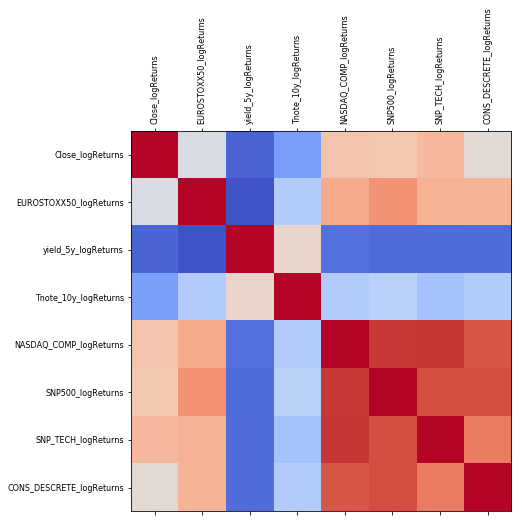

In [103]:
df = df_corr2.corr()
import matplotlib.cm as cm
size = 7
fig, ax = plt.subplots(figsize=(size, size))
ax.matshow(df,cmap=cm.get_cmap('coolwarm'), vmin=0,vmax=1)
plt.xticks(range(len(df.columns)), df.columns, rotation='vertical', fontsize=8);
plt.yticks(range(len(df.columns)), df.columns, fontsize=8);
df

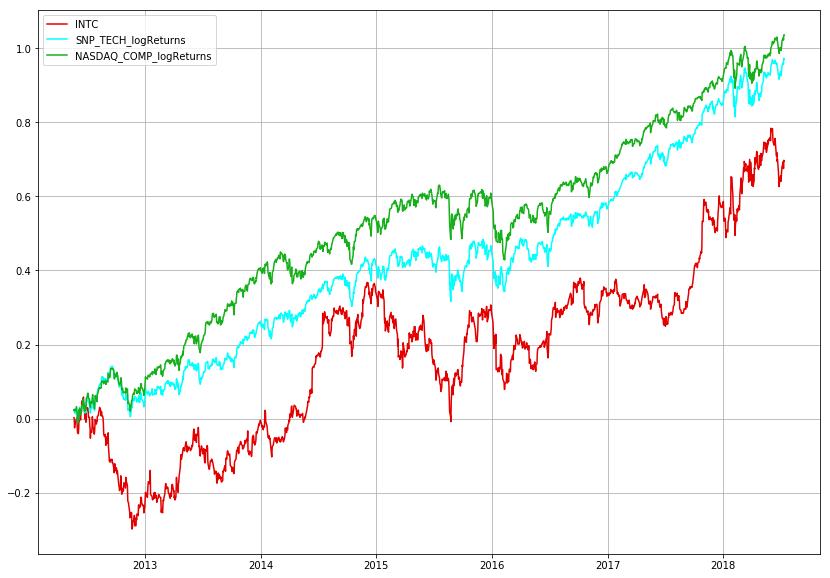

In [155]:
from matplotlib.pyplot import figure
figure(num=None, figsize=(14, 10))
plt.plot(np.cumsum(train_data[['Close_logReturns']]), color='xkcd:red',linestyle ='-')
plt.plot(np.cumsum(train_data[['SNP_TECH_logReturns']]),color='xkcd:cyan',linestyle ='-')
plt.plot(np.cumsum(train_data[['NASDAQ_COMP_logReturns']]),color='xkcd:green',linestyle ='-')
plt.grid(True,which ='both')
plt.legend(['INTC','SNP_TECH_logReturns','NASDAQ_COMP_logReturns'], loc='upper left')

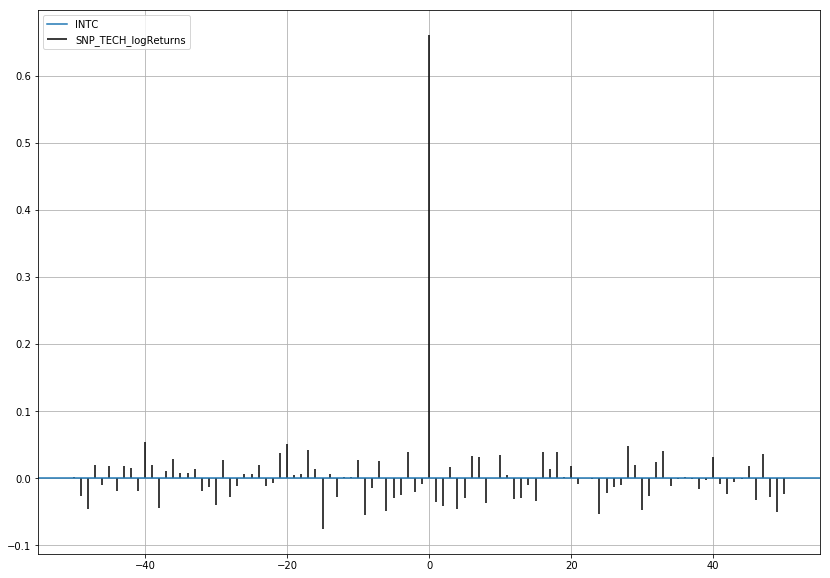

In [157]:
# show lagged cross correlation
import matplotlib.pyplot as plt
intc_arr = np.array((df_corr2[['Close_logReturns']]))
snptech_arr = np.array((df_corr2[['SNP_TECH_logReturns']]))
intc_arr = intc_arr.ravel()
snptech_arr = snptech_arr.ravel()
figure(num=None, figsize=(14, 10))
plt.xcorr(intc_arr,snptech_arr,maxlags=50, usevlines=1)
plt.grid(True)
plt.legend(['INTC','SNP_TECH_logReturns'], loc='upper left')
plt.show()

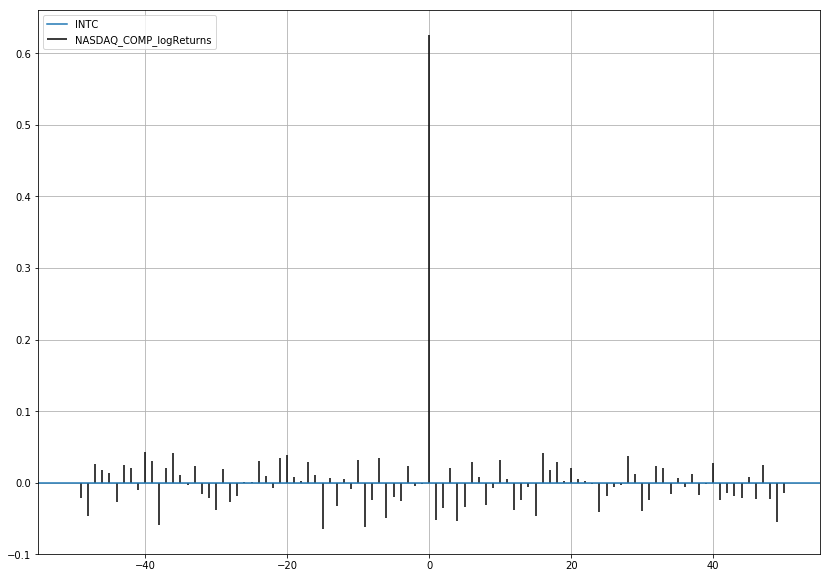

In [158]:
# show lagged cross correlation
import matplotlib.pyplot as plt
intc_arr = np.array((df_corr2[['Close_logReturns']]))
snptech_arr = np.array((df_corr2[['NASDAQ_COMP_logReturns']]))
intc_arr = intc_arr.ravel()
snptech_arr = snptech_arr.ravel()
figure(num=None, figsize=(14, 10))
plt.xcorr(intc_arr,snptech_arr,maxlags=50, usevlines=1)
plt.grid(True)
plt.legend(['INTC','NASDAQ_COMP_logReturns'], loc='upper left')
plt.show()

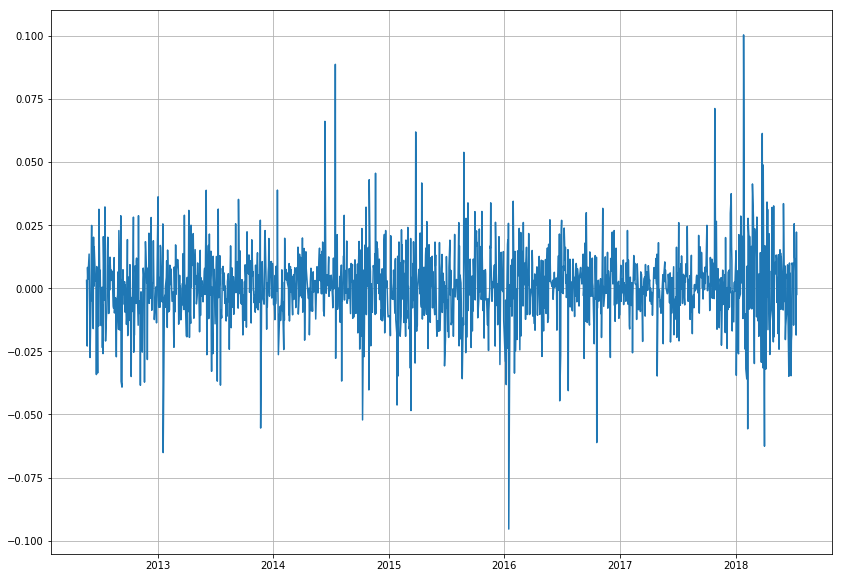

In [151]:
figure(num=None, figsize=(14, 10))
plt.plot(train_data[['Close_logReturns']])
plt.grid(True)

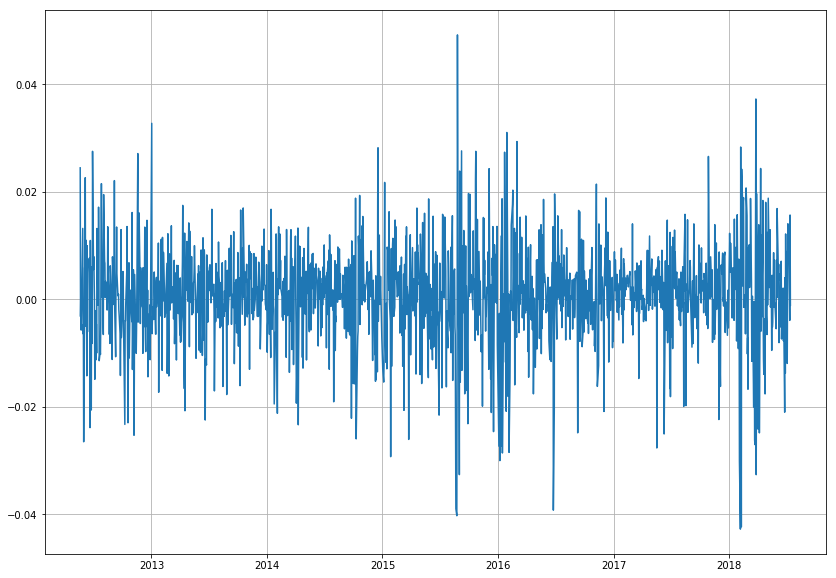

In [152]:
figure(num=None, figsize=(14, 10))
plt.plot(train_data[['SNP_TECH_logReturns']])
plt.grid(True)

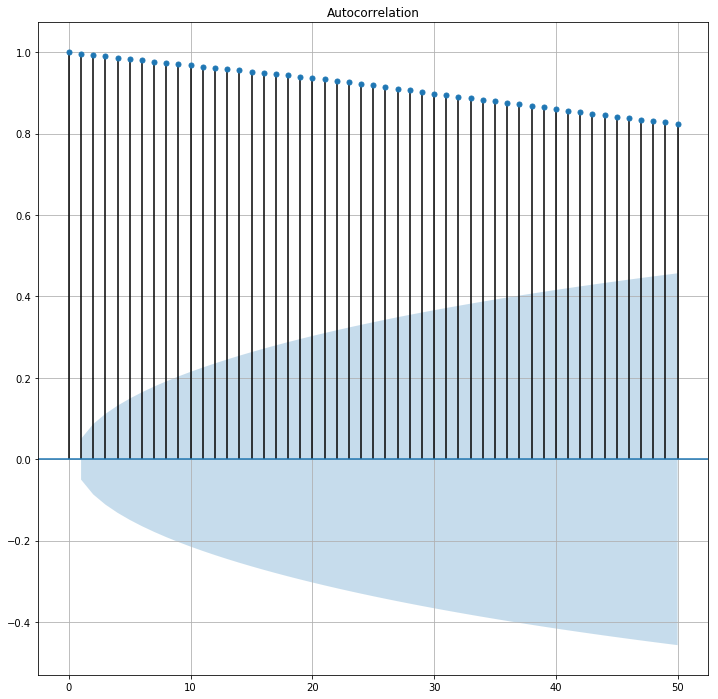

In [184]:
# plot auto correlation
from statsmodels.graphics.tsaplots import plot_acf
intc_arr = np.array(np.cumsum(train_data[['Close_logReturns']]))
intc_arr = intc_arr.ravel()
series = intc_arr
plt.rc("figure",figsize=(12,12))
plot_acf(series, lags=50,use_vlines=True)
plt.grid(True)

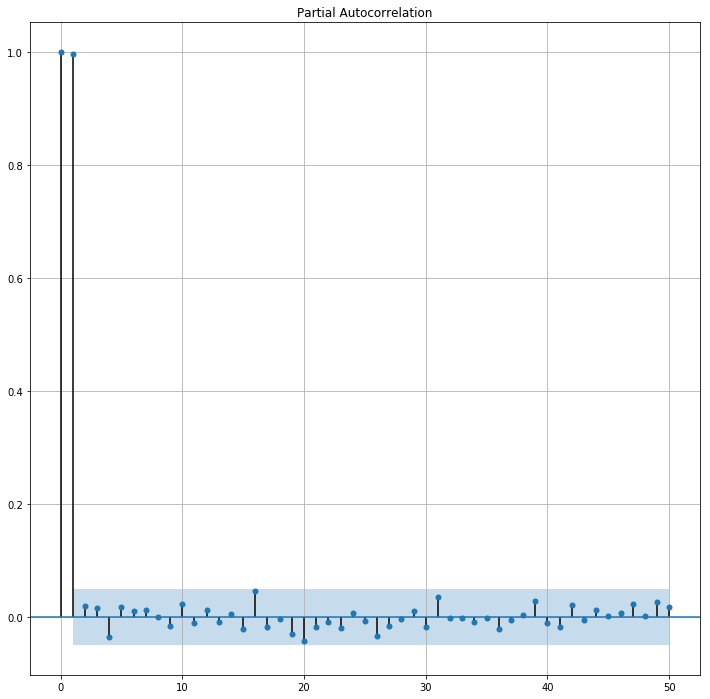

In [185]:
# plot auto correlation
from statsmodels.graphics.tsaplots import plot_pacf
plt.rc("figure",figsize=(12,12))
plot_pacf(series, lags=50,use_vlines=True)
plt.grid(True)

In [246]:
train_data

,Weekday,Daymonth,Month,Weakyear,High_logReturns,Low_logReturns,Close_logReturns,MSFT_logReturns,AMZN_logReturns,NVDA_logReturns,GOOG_logReturns,NFLX_logReturns,FB_logReturns,EUROSTOXX50_logReturns,SNP500_logReturns,CONS_DESCRETE_logReturns,SNP_TECH_logReturns,NASDAQ_COMP_logReturns,yield_5y_logReturns,Tnote_10y_logReturns,Volume_Scaled,ATR_Scaled,TSI_Scaled,OBV_Scaled
Date,,,,,,,,,,,,,,,,,,,,,,,,
2012-05-21,0,21,5,21,-0.014405,-0.014305,0.003064,0.016266,0.019725,0.017235,0.022578,0.025125,-0.116378,0.024675,0.015909,0.017462,0.024453,0.024324,-0.001124,0.023122,0.287905,0.270144,1.000000,0.287905
2012-05-22,1,22,5,21,0.003431,0.003887,-0.004599,0.000336,-0.012828,-0.012280,-0.021912,-0.057815,-0.093255,-0.005751,0.000486,0.003969,-0.003202,-0.002859,0.002247,0.022600,0.320239,0.267370,0.299555,-0.320239
2012-05-23,2,23,5,21,-0.029738,-0.033928,-0.022927,-0.022083,0.009015,0.024411,0.014311,0.060181,0.031749,-0.013428,0.001692,0.005345,0.001069,0.003881,0.003361,-0.034094,0.431062,0.354468,-0.393748,-0.431062
2012-05-24,3,24,5,21,0.010529,0.015529,0.008221,-0.001375,-0.009433,-0.026886,-0.009562,-0.023070,0.031680,-0.008439,0.001379,0.004624,-0.005712,-0.003775,0.004464,0.022858,0.258271,0.329825,-0.401581,0.258271
2012-05-25,4,25,5,21,0.002712,0.010220,0.003503,-0.000344,-0.010978,0.023665,-0.020299,-0.000712,-0.034497,0.002576,-0.002168,-0.001616,-0.002151,-0.000652,0.000000,-0.011364,0.133014,0.293853,-0.371630,0.133014
2012-05-29,1,29,5,22,0.018019,0.011278,0.013506,0.017059,0.008699,0.025479,0.004739,-0.011170,-0.101156,0.003302,0.011018,0.013768,0.013189,0.011723,0.002225,-0.005731,0.243828,0.295679,-0.269809,0.243828
2012-05-30,2,30,5,22,-0.004951,-0.002323,0.001532,-0.007470,-0.026040,-0.011863,-0.010334,-0.030709,-0.022796,-0.035418,-0.014439,-0.015850,-0.006394,-0.011783,-0.002225,-0.065305,0.230173,0.281371,-0.205559,0.230173
2012-05-31,3,31,5,22,-0.004592,-0.003883,-0.011160,-0.005126,0.017435,-0.011200,-0.012608,-0.059660,0.048807,0.003410,-0.002279,-0.002086,-0.004644,-0.003538,-0.003346,-0.024846,0.293824,0.273337,-0.190969,-0.293824
2012-06-01,4,1,6,22,-0.013905,-0.022827,-0.027464,-0.025678,-0.022274,-0.036874,-0.017156,-0.007754,-0.065620,-0.023341,-0.024951,-0.032063,-0.026484,-0.028652,0.002232,-0.078472,0.279955,0.287311,-0.231291,-0.279955
